## Diferentes estratégias de blending das imagens do panorama

Setup do notebook

In [1]:
import cv2
import numpy as np

from canon.utils import image_utils, notebook_utils
from canon.T1.process import feature_extraction
from canon.T1.plotting import plotting

### Integração a recursive_panorama.py

Classe que implementa as etapas de criação de um panorama

In [2]:
class ImageStitching:
    """containts the utilities required to stitch images"""

    def __init__(self, query_photo, train_photo):
        super().__init__()
        width_query_photo = query_photo.shape[1]
        width_train_photo = train_photo.shape[1]
        lowest_width = min(width_query_photo, width_train_photo)
        smoothing_window_percent = 0.10 # consider increasing or decreasing[0.00, 1.00] 
        self.smoothing_window_size = max(100, min(smoothing_window_percent * lowest_width, 1000))

    def give_gray(self, image):
        """receives an image array and returns grayscaled image

        Args:
            image (numpy array): array of images

        Returns:
            image (numpy array): same as image input
            photo_gray (numpy array): grayscaled images
        """
        photo_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        return image, photo_gray



    @staticmethod
    def _sift_detector(image):
        """Applies SIFT algorithm to the given image

        Args:
            image (numpy array): input image

        Returns:
            keypoints, features
        """
        descriptor = cv2.SIFT_create()
        keypoints, features = descriptor.detectAndCompute(image, None)

        return keypoints, features

    def create_and_match_keypoints(self, features_train_image, features_query_image):
        """Creates and Matches keypoints from the SIFT features using Brute Force matching
        by checking the L2 norm of the feature vector

        Args:
            features_train_image: SIFT features of train image
            features_query_image: SIFT features of query image

        Returns:
            matches (List): matches in features of train and query image
        """
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

        best_matches = bf.match(features_train_image, features_query_image)
        raw_matches = sorted(best_matches, key=lambda x: x.distance)

        return raw_matches

    def compute_homography(
        self, keypoints_train_image, keypoints_query_image, matches, reprojThresh
    ):
        """Computes the Homography to map images to a single plane,
        uses RANSAC algorithm to find the best matches iteratively.

        Args:
            keypoints_train_image: keypoints found using SIFT in train image
            keypoints_query_image: keypoints found using SIFT in query image
            matches: matches found using Brute Force
            reprojThresh: threshold for error

        Returns:
            M (Tuple): (matches, Homography matrix, status)
        """
        keypoints_train_image = np.float32(
            [keypoint.pt for keypoint in keypoints_train_image]
        )
        keypoints_query_image = np.float32(
            [keypoint.pt for keypoint in keypoints_query_image]
        )

        if len(matches) >= 4:
            points_train = np.float32(
                [keypoints_train_image[m.queryIdx] for m in matches]
            )
            points_query = np.float32(
                [keypoints_query_image[m.trainIdx] for m in matches]
            )

            H, status = cv2.findHomography(
                points_train, points_query, cv2.RANSAC, reprojThresh
            )

            return (matches, H, status)

        else:
            print(f"Minimum match count not satisfied cannot get homopgrahy")
            return None

    

In [3]:
class Blender:
    """Class to blend two images using different blending methods"""

    def __init__(self, blending_method="feathering"):
        self.method = blending_method

    def _create_linear_mask(self, query_image, train_image, version):
        """Creates the mask using query and train images for blending the images,
        using a gaussian smoothing window/kernel

        Args:
            query_image (numpy array)
            train_image (numpy array)
            version (str) == 'left_image' or 'right_image'

        Returns:
            masks
        """
        height_query_photo = query_image.shape[0]
        width_query_photo = query_image.shape[1]
        width_train_photo = train_image.shape[1]
        height_panorama = height_query_photo
        width_panorama = width_query_photo + width_train_photo
        lowest_width = min(width_query_photo, width_train_photo)
        smoothing_window_percent = 0.10 # consider increasing or decreasing[0.00, 1.00] 
        smoothing_window_size = max(100, min(smoothing_window_percent * lowest_width, 1000))

        offset = int(smoothing_window_size / 2)
        barrier = query_image.shape[1] - int(smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version == "left_image":
            mask[:, barrier - offset : barrier + offset] = np.tile(
                np.linspace(1, 0, 2 * offset).T, (height_panorama, 1)
            )
            mask[:, : barrier - offset] = 1
        else:
            mask[:, barrier - offset : barrier + offset] = np.tile(
                np.linspace(0, 1, 2 * offset).T, (height_panorama, 1)
            )
            mask[:, barrier + offset :] = 1
        return cv2.merge([mask, mask, mask])

    def _blending_feathering(self, query_image, train_image, homography_matrix):
        """blends both query and train image via the homography matrix,
        and ensures proper blending and smoothing using masks created in create_masks()
        to give a seamless panorama.

        Args:
            query_image (numpy array)
            train_image (numpy array)
            homography_matrix (numpy array): Homography to map images to a single plane

        Returns:
            panoramic image (numpy array)
        """
        height_img1 = query_image.shape[0]
        width_img1 = query_image.shape[1]
        width_img2 = train_image.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 + width_img2

        panorama1 = np.zeros((height_panorama, width_panorama, 3))
        mask1 = self._create_linear_mask(query_image, train_image, version="left_image")
        panorama1[0 : query_image.shape[0], 0 : query_image.shape[1], :] = query_image
        panorama1 *= mask1
        mask2 = self._create_linear_mask(query_image, train_image, version="right_image")
        panorama2 = (
            cv2.warpPerspective(
                train_image, homography_matrix, (width_panorama, height_panorama)
            )
            * mask2
        )
        result = panorama1 + panorama2

        # remove extra blackspace
        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1

        final_result = result[min_row:max_row, min_col:max_col, :]

        return final_result

    def _build_laplacian_pyramid(self, img, levels):
        gp = [img.astype(np.float32)]
        for _ in range(levels):
            gp.append(cv2.pyrDown(gp[-1]))
        lp = [gp[-1]]
        for i in range(levels-1, -1, -1):
            size = (gp[i].shape[1], gp[i].shape[0])
            ge = cv2.pyrUp(gp[i+1], dstsize=size)
            lp.append(cv2.subtract(gp[i], ge))
        return lp[::-1]  # from fine to coarse
    
    def _blending_multiband(self, query_image, train_image, homography_matrix, levels=5):
        """
        Performs multi-band (pyramid) blending of two images into a panorama.

        Args:
            query_image (numpy array): Left/base image
            train_image (numpy array): Right image to warp and blend
            homography_matrix (numpy array): Homography to align train_image
            levels (int): Number of pyramid levels for blending

        Returns:
            final_result (numpy array): Seamlessly blended panorama
        """
        # Step 1: Warp train_image to panorama space
        height_img1, width_img1 = query_image.shape[:2]
        height_panorama, width_panorama = height_img1, width_img1 + train_image.shape[1]

        warped_train = cv2.warpPerspective(train_image, homography_matrix,
                                        (width_panorama, height_panorama))

        # Step 2: Place query_image in panorama space
        panorama = np.zeros((height_panorama, width_panorama, 3), dtype=np.float32)
        panorama[0:height_img1, 0:width_img1, :] = query_image.astype(np.float32)

        # Step 3: Create blending mask
        mask = self._create_linear_mask(query_image, train_image, version="left_image").astype(np.float32)

        # Step 4: Build Gaussian pyramids for masks
        gp_mask = [mask]
        for _ in range(levels):
            gp_mask.append(cv2.pyrDown(gp_mask[-1]))

        # Step 5: Build Laplacian pyramids for images
        lp_panorama = self._build_laplacian_pyramid(panorama, levels)
        lp_warped_train = self._build_laplacian_pyramid(warped_train, levels)

        # Step 6: Blend pyramids using masks
        blended_pyramid = []
        for l1, l2, m in zip(lp_panorama, lp_warped_train, gp_mask):
            blended = l1 * m + l2 * (1 - m)
            blended_pyramid.append(blended)

        # Step 7: Reconstruct blended image
        result = blended_pyramid[-1]
        for i in range(levels - 1, -1, -1):
            size = (blended_pyramid[i].shape[1], blended_pyramid[i].shape[0])
            result = cv2.pyrUp(result, dstsize=size)
            result = cv2.add(result, blended_pyramid[i])

        # Step 8: Crop black borders
        result = np.clip(result, 0, 255).astype(np.uint8)
        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]

        return final_result

    def blend_images(self, query_image, train_image, homography_matrix):
        """Blends two images using the specified method.

        Args:
            query_image (numpy array): Left/base image
            train_image (numpy array): Right image to warp and blend
            homography_matrix (numpy array): Homography to align train_image
            method (str): Blending method - "feathering" or "multiband"

        Returns:
            final_result (numpy array): Blended panorama
        """
        if self.method == "feathering":
            return self._blending_feathering(query_image, train_image, homography_matrix)
        elif self.method == "multiband":
            return self._blending_multiband(query_image, train_image, homography_matrix)
        else:
            raise ValueError("Invalid blending method. Choose 'feathering' or 'multiband'.")

Função recursiva para criação do panorama

In [4]:
def recurse_tree(image_list, blender):
    """Versão em árvore balanceada para juntar imagens."""
    n = len(image_list)
    if n == 1:
        return image_list[0]
    elif n == 2:
        result, _ = forward(image_list[0], image_list[1], blender)
        return result
    else:
        mid = n // 2
        left = recurse_tree(image_list[:mid], blender)
        right = recurse_tree(image_list[mid:], blender)
        result, _ = forward(left, right, blender)
        return result
    
def forward(query_photo, train_photo, blender):
    """Runs a forward pass using the ImageStitching() class in utils.py.
    Takes in a query image and train image and runs entire pipeline to return
    a panoramic image.

    Args:
        query_photo (numpy array): query image
        train_photo (nnumpy array): train image

    Returns:
        result image (numpy array): RGB result image
    """
    image_stitching = ImageStitching(query_photo, train_photo)
    _, query_photo_gray = image_stitching.give_gray(query_photo)  # left image
    _, train_photo_gray = image_stitching.give_gray(train_photo)  # right image

    keypoints_train_image, features_train_image = image_stitching._sift_detector(
        train_photo_gray
    )
    keypoints_query_image, features_query_image = image_stitching._sift_detector(
        query_photo_gray
    )

    matches = image_stitching.create_and_match_keypoints(
        features_train_image, features_query_image
    )

    mapped_feature_image = cv2.drawMatches(
                        train_photo,
                        keypoints_train_image,
                        query_photo,
                        keypoints_query_image,
                        matches[:100],
                        None,
                        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    M = image_stitching.compute_homography(
        keypoints_train_image, keypoints_query_image, matches, reprojThresh=4
    )

    if M is None:
        return "Error cannot stitch images"

    (matches, homography_matrix, status) = M

    result = blender.blend_images(
        query_photo, train_photo, homography_matrix
    )

    result_rgb = np.uint8(result)
    mapped_feature_image_rgb = np.uint8(mapped_feature_image)

    return result_rgb, mapped_feature_image_rgb

Função principal

In [5]:
def create_panorama(dataset, blending_method="feathering"):
    # Carrega as imagens
    images_data = image_utils.load_images(dataset)
    panorama_images = [images_data[str(i)] for i in range(1, len(images_data)+1)]

    if len(panorama_images) < 2:
        print("⚠️ É necessário pelo menos duas imagens para criar panorama.")
        exit(1)

    # Reduz tamanho das imagens para acelerar o processamento
    scale_percent = 50  # reduz para 50% do tamanho original, ajuste conforme necessário
    resized_images = []
    for img in panorama_images:
        w = int(img.shape[1] * scale_percent / 100)
        h = int(img.shape[0] * scale_percent / 100)
        resized_img = cv2.resize(img, (w, h), interpolation=cv2.INTER_AREA)
        resized_images.append(resized_img)

    # Converte de BGR para RGB
    panorama_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in resized_images]

    # Cria panorama usando a função recursiva
    blender = Blender(blending_method)
    panorama = recurse_tree(panorama_images, blender)

    # Converte de volta para BGR para salvar com OpenCV
    panorama_bgr = cv2.cvtColor(panorama, cv2.COLOR_RGB2BGR)

    # Exibe os panoramas
    notebook_utils.show_image(panorama_bgr)

Teste do panorama para diferentes datasets

Criando panorama com feathering...
Criando panorama com multiband...


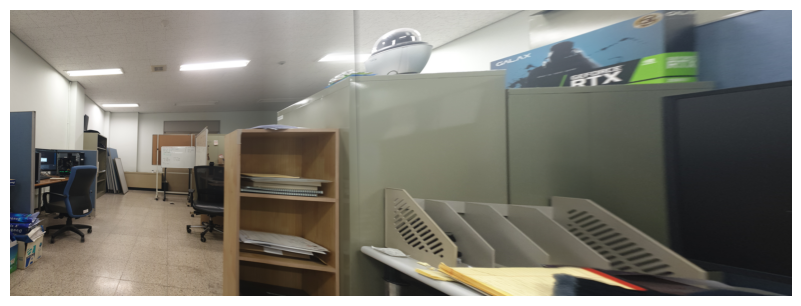

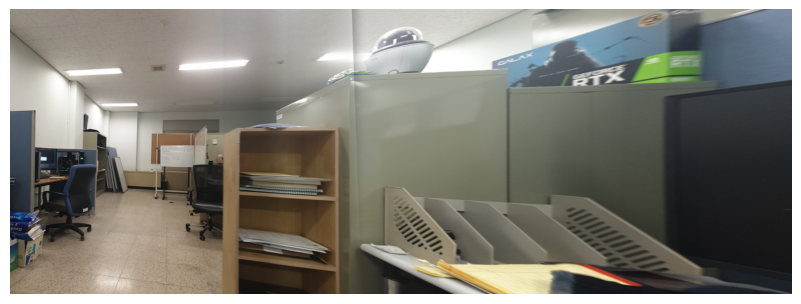

In [6]:
dataset = "T1/raw/PanoramaWebDataset"

print("Criando panorama com feathering...")
create_panorama(dataset, blending_method="feathering")

print("Criando panorama com multiband...")
create_panorama(dataset, blending_method="multiband")

Criando panorama com feathering...
Criando panorama com multiband...


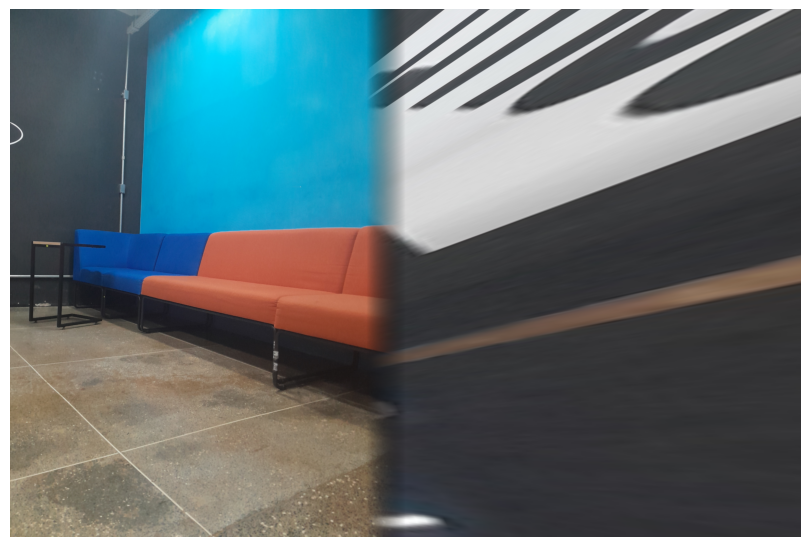

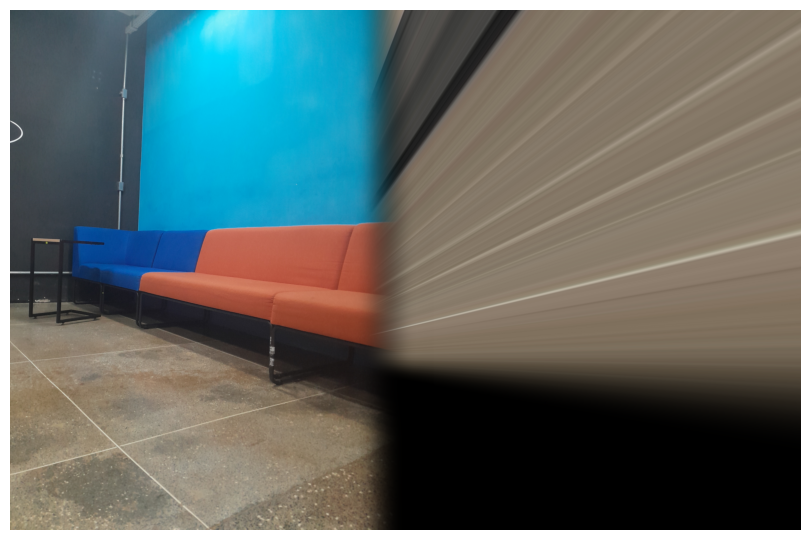

In [7]:
dataset = "T1/raw/ICInterior"

print("Criando panorama com feathering...")
create_panorama(dataset, blending_method="feathering")

print("Criando panorama com multiband...")
create_panorama(dataset, blending_method="multiband")

Criando panorama com feathering...
Criando panorama com multiband...


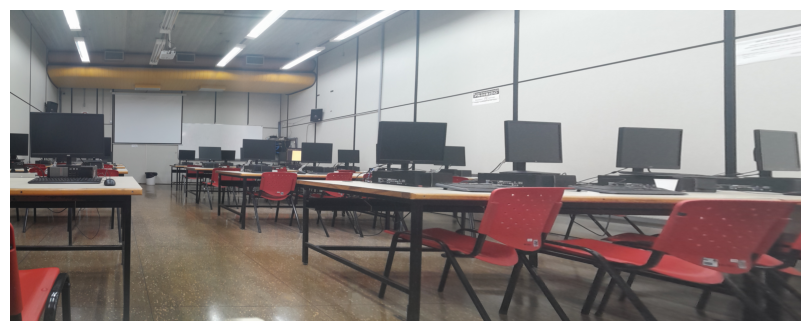

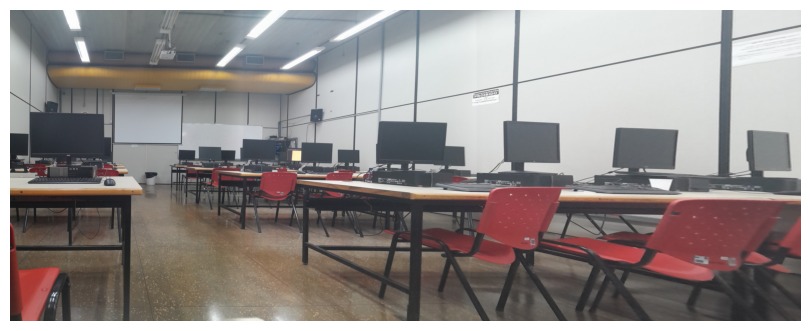

In [8]:
dataset = "T1/raw/Sala303"

print("Criando panorama com feathering...")
create_panorama(dataset, blending_method="feathering")

print("Criando panorama com multiband...")
create_panorama(dataset, blending_method="multiband")

Criando panorama com feathering...
Criando panorama com multiband...


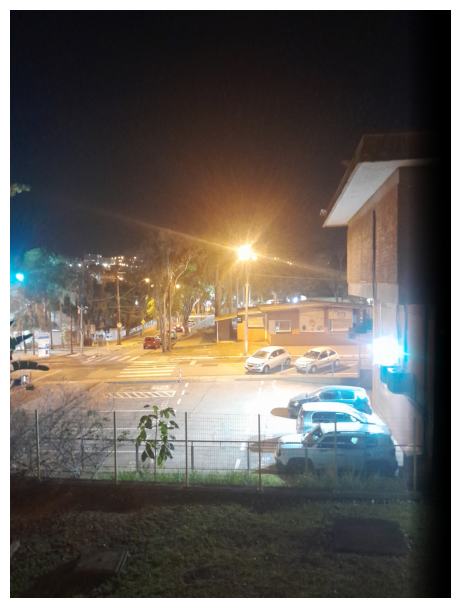

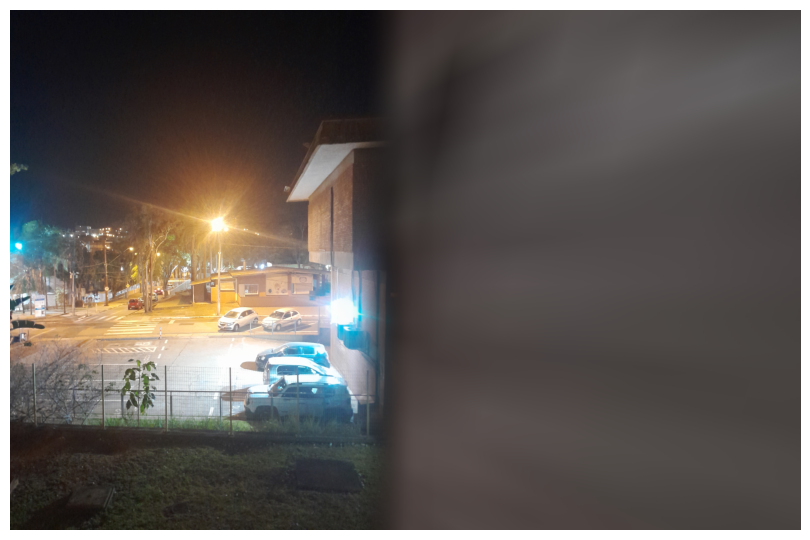

In [9]:
dataset = "T1/raw/CBExteriorNoturno"

print("Criando panorama com feathering...")
create_panorama(dataset, blending_method="feathering")

print("Criando panorama com multiband...")
create_panorama(dataset, blending_method="multiband")

### Integração a panorama.py

In [10]:
def find_best_center_image(images: list) -> int:
    """
    Encontra o índice da melhor imagem de referência para o panorama.
    A melhor imagem é a que tem o maior número de correspondências com as outras.
    """
    num_images = len(images)
    match_counts = [0] * num_images
    kp_descs = [feature_extraction.SIFT(img, nfeatures=1000) for img in images]

    bf = cv2.BFMatcher(cv2.NORM_L2)

    for i in range(num_images):
        for j in range(i + 1, num_images):
            _, des1 = kp_descs[i]
            _, des2 = kp_descs[j]

            if des1 is None or des2 is None:
                continue

            matches = bf.knnMatch(des1, des2, k=2)
            good_matches = plotting.david_lowe_ratio_test(matches)
            
            match_counts[i] += len(good_matches)
            match_counts[j] += len(good_matches)
    
    best_image_idx = np.argmax(match_counts)
    print(f"A melhor imagem central para o panorama é a imagem {best_image_idx + 1}.")
    return best_image_idx

def stitch_panorama_tree_based(images: list, blender) -> np.ndarray:
    if not images:
        return None

    center_idx = find_best_center_image(images)
    center_image = images[center_idx]
    
    H_matrices = {}
    H_matrices[center_idx] = np.identity(3)
    
    for i, img in enumerate(images):
        if i == center_idx:
            H_matrices[i] = np.identity(3)
            continue
        
        kp1, des1 = feature_extraction.SIFT(center_image, nfeatures=5000, contrastThreshold=0.02, edgeThreshold=15)
        kp2, des2 = feature_extraction.SIFT(img, nfeatures=5000, contrastThreshold=0.02, edgeThreshold=15)

        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.knnMatch(des1, des2, k=2)
        good_matches = plotting.david_lowe_ratio_test(matches)

        if len(good_matches) > 10:
            src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
            H_matrices[i] = H
        else:
            print(f"Não há correspondências suficientes para a imagem {i+1}, pulando.")
            H_matrices[i] = None
    
     # --- Step 1: Find panorama bounding box ---
    corners = []
    for i, img in enumerate(images):
        if H_matrices.get(i) is None:
            continue
        h, w = img.shape[:2]
        img_corners = np.array([[0,0],[w,0],[w,h],[0,h]], dtype=np.float32).reshape(-1,1,2)
        warped_corners = cv2.perspectiveTransform(img_corners, H_matrices[i])
        corners.append(warped_corners)

    corners = np.vstack(corners)
    [xmin, ymin] = np.int32(corners.min(axis=0).ravel())
    [xmax, ymax] = np.int32(corners.max(axis=0).ravel())

    # Translation to handle negative coords (left side)
    translation = np.array([[1, 0, -xmin],
                            [0, 1, -ymin],
                            [0, 0, 1]], dtype=np.float64)

    panorama_width  = xmax - xmin
    panorama_height = ymax - ymin
    
    # --- Step 2: Initialize canvas with translated center image ---
    final_canvas = np.zeros((panorama_height, panorama_width, 3), dtype=np.uint8)
    final_canvas = cv2.warpPerspective(center_image, translation, (panorama_width, panorama_height))

    # --- Step 3: Blend all images ---
    for i, img in enumerate(images):
        if i == center_idx:
            continue
        if H_matrices.get(i) is None:
            print(f"AVISO: Imagem {i+1} não foi inserida no panorama final.")
            continue

        H = translation @ H_matrices[i]
        final_canvas = blender.blend_images(final_canvas, img, H)

    final_canvas = np.clip(final_canvas, 0, 255).astype(np.uint8)
    return final_canvas

def crop_black_borders_completely(img: np.ndarray) -> np.ndarray:
    """Removes black borders from an image."""
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    return img[y:y+h, x:x+w]

A melhor imagem central para o panorama é a imagem 4.
Final panorama saved successfully.


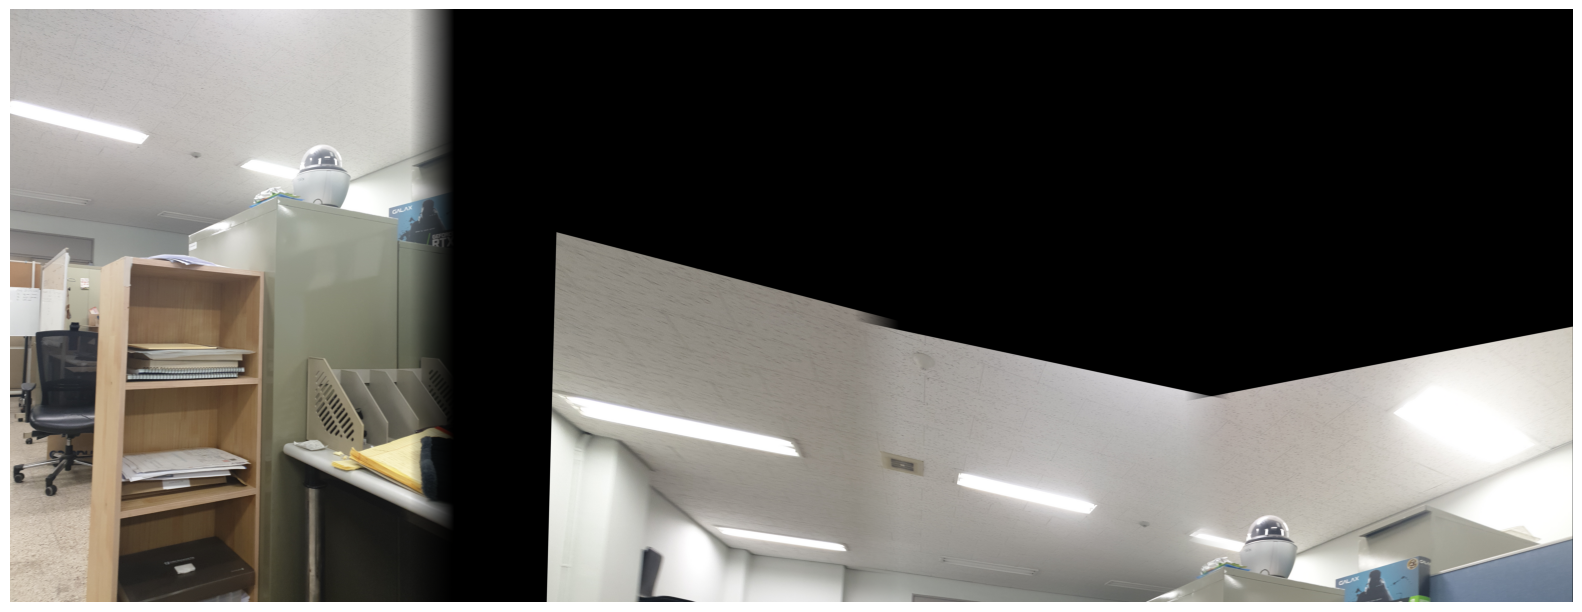

In [12]:
images_data = image_utils.load_images("T1/raw/PanoramaWebDataset")
panorama_images = [images_data[str(i)] for i in range(1, 6)]

blender = Blender()
final_panorama_with_borders = stitch_panorama_tree_based(panorama_images, blender)

if final_panorama_with_borders is not None:
    final_panorama = crop_black_borders_completely(final_panorama_with_borders)
    notebook_utils.show_image(final_panorama_with_borders)
    print("Final panorama saved successfully.")
else:
    print("Failed to create panorama.")